In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

In [94]:
# -----------------------------
# 1. 读取数据
# -----------------------------

data = "/Users/richard/Downloads/algorithm4/data.csv"
df = pd.read_csv(data)  

# 日期转换
df["calendar_date"] = pd.to_datetime(df["calendar_date"], format="%Y/%m/%d", errors="coerce")
df = df.dropna(subset=["calendar_date"])

df = df[["calendar_date", "quantity", "day_of_week", "holiday"]]

In [95]:
df

,calendar_date,quantity,day_of_week,holiday
0,2016-01-01,282,5,NewYearsDay
1,2016-01-02,344,6,NewYearsDay
2,2016-01-03,378,7,NewYearsDay
3,2016-01-04,253,1,NaN
4,2016-01-05,279,2,NaN
...,...,...,...,...
2242,2022-02-23,575,3,NaN
2243,2022-02-24,573,4,NaN
2244,2022-02-25,580,5,NaN
2245,2022-02-26,614,6,NaN


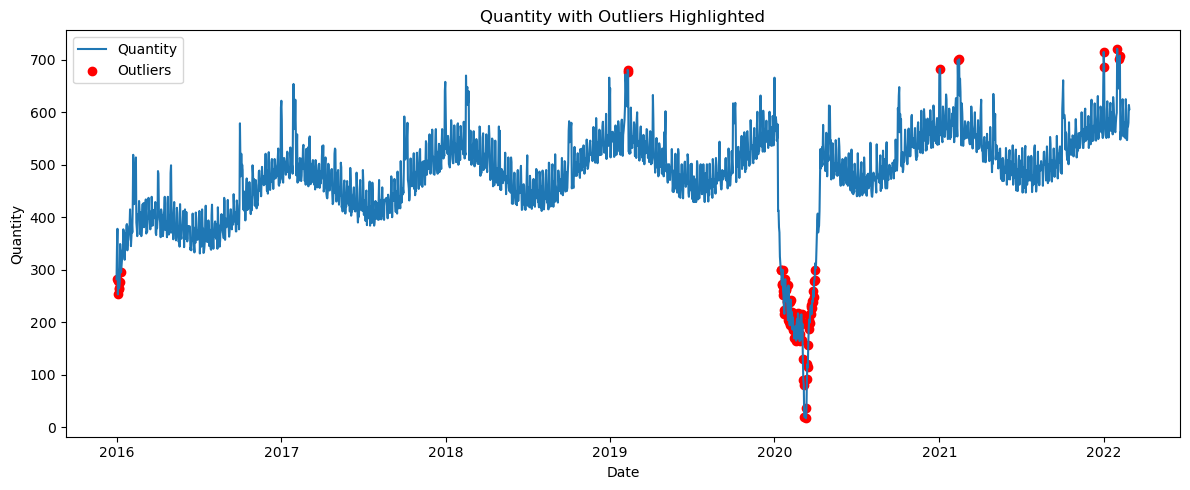

In [96]:
# -----------------------------
# 2. 各列异常检查 + 可视化
# -----------------------------
# --- quantity 检查 ---

df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce")
df = df.dropna(subset=["quantity"])

Q1 = df["quantity"].quantile(0.25)
Q3 = df["quantity"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df["quantity_outlier"] = (df["quantity"] < lower_bound) | (df["quantity"] > upper_bound)
outliers = df[df["quantity_outlier"]]

# 画图：销量 + 异常值
plt.figure(figsize=(12, 5))
plt.plot(df["calendar_date"], df["quantity"], label="Quantity")
plt.scatter(outliers["calendar_date"], outliers["quantity"], color='red', label="Outliers")
plt.title("Quantity with Outliers Highlighted")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
plt.show()


假期种类： ['Newyearsday' 'Nan' 'Cnyeve' 'Cny' 'Qingming' 'Laborsday'
 "Children'S Day" 'Dragonboatfestival' 'Moonfestival' 'Nationalday']


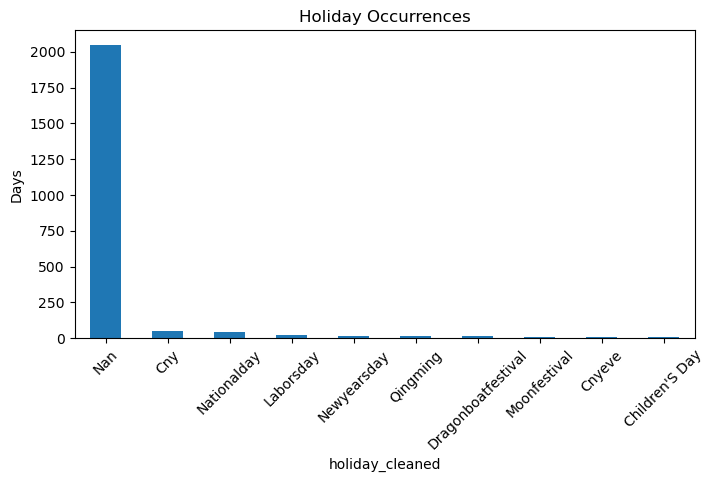

In [97]:
df["holiday_cleaned"] = df["holiday"].astype(str).str.strip().str.title()

# 显示独特的 holiday 值
unique_holidays = df["holiday_cleaned"].dropna().unique()
print("假期种类：", unique_holidays)

# 映射不规范的假期名称为标准写法
# holiday_map = {
#     "Newyearsday": "New Year's Day",
#     "Christmas": "Christmas Day",
#     "Xmas": "Christmas Day",
#     # 添加更多映射
# }
# # df["holiday_cleaned"] = df["holiday_cleaned"].replace(holiday_map)

# 可视化节假日分布
plt.figure(figsize=(8, 4))
df["holiday_cleaned"].value_counts().plot(kind="bar", title="Holiday Occurrences")
plt.ylabel("Days")
plt.xticks(rotation=45)
plt.show()


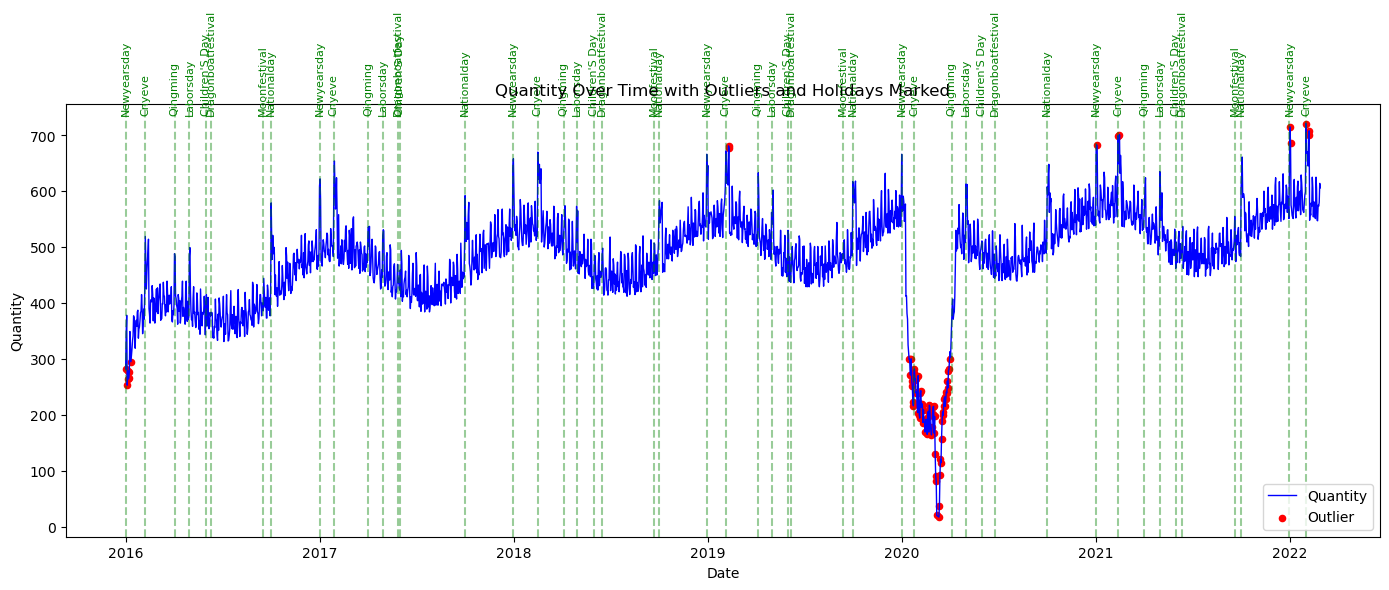

In [98]:
# 筛选有效节假日
holiday_df = df[~df["holiday_cleaned"].isin(["Nan", "nan", "NaN", "None"]) & df["holiday_cleaned"].notnull()]
holiday_df = holiday_df[["calendar_date", "holiday_cleaned"]].drop_duplicates().sort_values("calendar_date").reset_index(drop=True)

# 找到非连续的节假日起点（与前一个日期相差 >= 2 天）
holiday_df["prev_date"] = holiday_df["calendar_date"].shift(1)
holiday_df["gap"] = (holiday_df["calendar_date"] - holiday_df["prev_date"]).dt.days
# 标注起点行：第一行或 gap >= 2
holiday_markers = holiday_df[(holiday_df["gap"].isna()) | (holiday_df["gap"] >= 2)]

# 画图
plt.figure(figsize=(14, 6))
plt.plot(df["calendar_date"], df["quantity"], label="Quantity", color='blue', linewidth=1)
plt.scatter(df.loc[df["quantity_outlier"], "calendar_date"],
            df.loc[df["quantity_outlier"], "quantity"],
            color='red', label="Outlier", s=20)

# 添加节假日竖线和标签
for _, row in holiday_markers.iterrows():
    plt.axvline(x=row["calendar_date"], color='green', linestyle='--', alpha=0.4)
    plt.text(row["calendar_date"], df["quantity"].max()*1.02,
             row["holiday_cleaned"], rotation=90, fontsize=8,
             verticalalignment='bottom', horizontalalignment='center', color='green')

plt.title("Quantity Over Time with Outliers and Holidays Marked")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
plt.show()

第 1 轮：找到 74 条异常值需要删除。
第 2 轮：找到 3 条异常值需要删除。
第 3 轮：找到 0 条异常值需要删除。


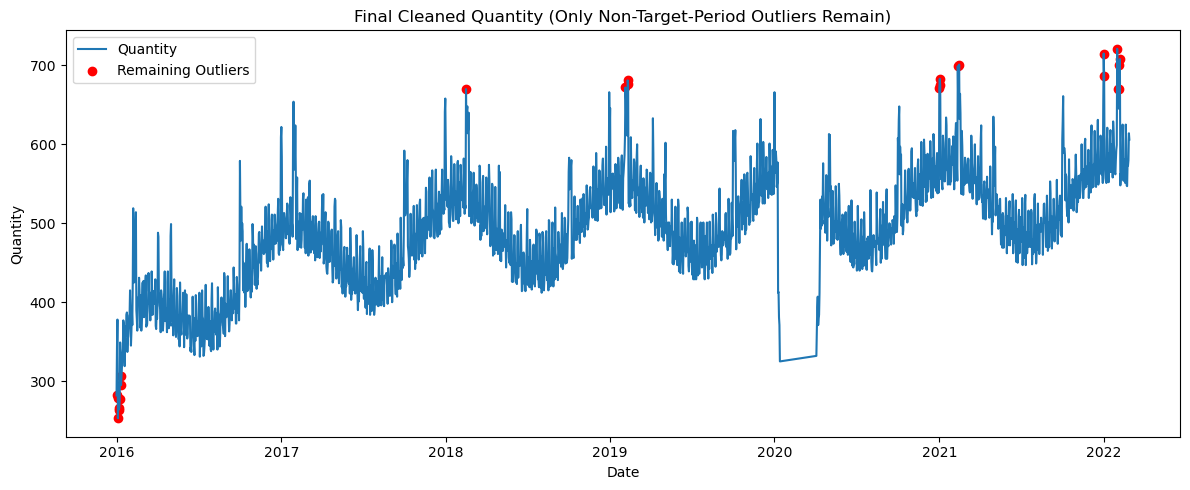

In [99]:
# 1. 重新复制原始 df，避免污染
df_cleaned_ultra = df.copy()

# 2. 将日期列确保为 datetime 类型（保险起见）
df_cleaned_ultra["calendar_date"] = pd.to_datetime(df_cleaned_ultra["calendar_date"])

# 3. 开始循环清除异常值
start_date = pd.to_datetime("2019-11-01")
end_date = pd.to_datetime("2020-06-30")

iteration = 0
while True:
    iteration += 1

    # IQR 方法检测异常值
    Q1 = df_cleaned_ultra["quantity"].quantile(0.25)
    Q3 = df_cleaned_ultra["quantity"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 标记异常值
    df_cleaned_ultra["quantity_outlier"] = (df_cleaned_ultra["quantity"] < lower_bound) | (df_cleaned_ultra["quantity"] > upper_bound)

    # 找出目标日期范围内的异常值
    mask_to_remove = (
        df_cleaned_ultra["quantity_outlier"] &
        (df_cleaned_ultra["calendar_date"] >= start_date) &
        (df_cleaned_ultra["calendar_date"] <= end_date)
    )

    to_remove_count = mask_to_remove.sum()
    print(f"第 {iteration} 轮：找到 {to_remove_count} 条异常值需要删除。")

    if to_remove_count == 0:
        break  # 没有异常了，退出循环

    # 删除这些异常值
    df_cleaned_ultra = df_cleaned_ultra[~mask_to_remove].copy()

# 4. 最终保留的异常值（只保留非目标日期范围的）
remaining_outliers = df_cleaned_ultra[df_cleaned_ultra["quantity_outlier"]]

# 5. 可视化结果
plt.figure(figsize=(12, 5))
plt.plot(df_cleaned_ultra["calendar_date"], df_cleaned_ultra["quantity"], label="Quantity")
plt.scatter(remaining_outliers["calendar_date"], remaining_outliers["quantity"], color='red', label="Remaining Outliers")
plt.title("Final Cleaned Quantity (Only Non-Target-Period Outliers Remain)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
plt.show()

In [100]:
# -----------------------------
# 4. 划分训练集和测试集
# -----------------------------
train_df = df_cleaned_ultra[df_cleaned_ultra["calendar_date"] < "2022-01-01"]
test_df = df_cleaned_ultra[(df_cleaned_ultra["calendar_date"] >= "2022-01-01") & (df_cleaned_ultra["calendar_date"] <= "2022-02-27")]


In [101]:
test_df

,calendar_date,quantity,day_of_week,holiday,quantity_outlier,holiday_cleaned
2189,2022-01-01,715,6,NewYearsDay,True,Newyearsday
2190,2022-01-02,686,7,NewYearsDay,True,Newyearsday
2191,2022-01-03,575,1,NaN,False,Nan
2192,2022-01-04,568,2,NaN,False,Nan
2193,2022-01-05,557,3,NaN,False,Nan
2194,2022-01-06,553,4,NaN,False,Nan
2195,2022-01-07,551,5,NaN,False,Nan
2196,2022-01-08,605,6,NaN,False,Nan
2197,2022-01-09,621,7,NaN,False,Nan
2198,2022-01-10,574,1,NaN,False,Nan


In [103]:
# -----------------------------
# 5. 构建 Prophet 模型
# -----------------------------

# 筛选用于预测区间（2022-01-01 ~ 2022-02-27）的节假日
# mask = (["calendar_date"] >= train_df["calendar_date"].min()) & (df_cleaned_ultra["calendar_date"] <= "2022-02-27")

holidays_df = df_cleaned_ultra.loc[
    mask & df_cleaned_ultra["holiday"].notna(), ["calendar_date", "holiday"]
].drop_duplicates()

# 重命名为 Prophet 所需格式
holidays_df = holidays_df.rename(columns={"calendar_date": "ds"})
holidays_df["ds"] = pd.to_datetime(holidays_df["ds"])
holidays_df["lower_window"] = 0
holidays_df["upper_window"] = 0

# 构造 Prophet 所需的 holidays DataFrame
prophet_holidays = holidays_df[["holiday", "ds", "lower_window", "upper_window"]]

# 准备训练数据（Prophet 要求列名为 ds, y）
train_df_prophet = train_df.rename(columns={"calendar_date": "ds", "quantity": "y"})
train_df_prophet["day_of_week"] = train_df_prophet["ds"].dt.weekday  # 添加星期几作为额外回归量

# 初始化 Prophet 模型并加入额外回归量
m = Prophet(interval_width=0.95, holidays=prophet_holidays)
m.add_regressor("day_of_week")

# 拟合模型
m.fit(train_df_prophet)

# 构造未来数据框（用于预测）
future = pd.DataFrame({
    "ds": pd.date_range(start="2022-01-01", end="2022-02-27")
})
future["day_of_week"] = future["ds"].dt.weekday

# 进行预测
forecast = m.predict(future)

09:57:53 - cmdstanpy - INFO - Chain [1] start processing
09:57:53 - cmdstanpy - INFO - Chain [1] done processing


预测 MAPE: 0.0211 (2.11%)


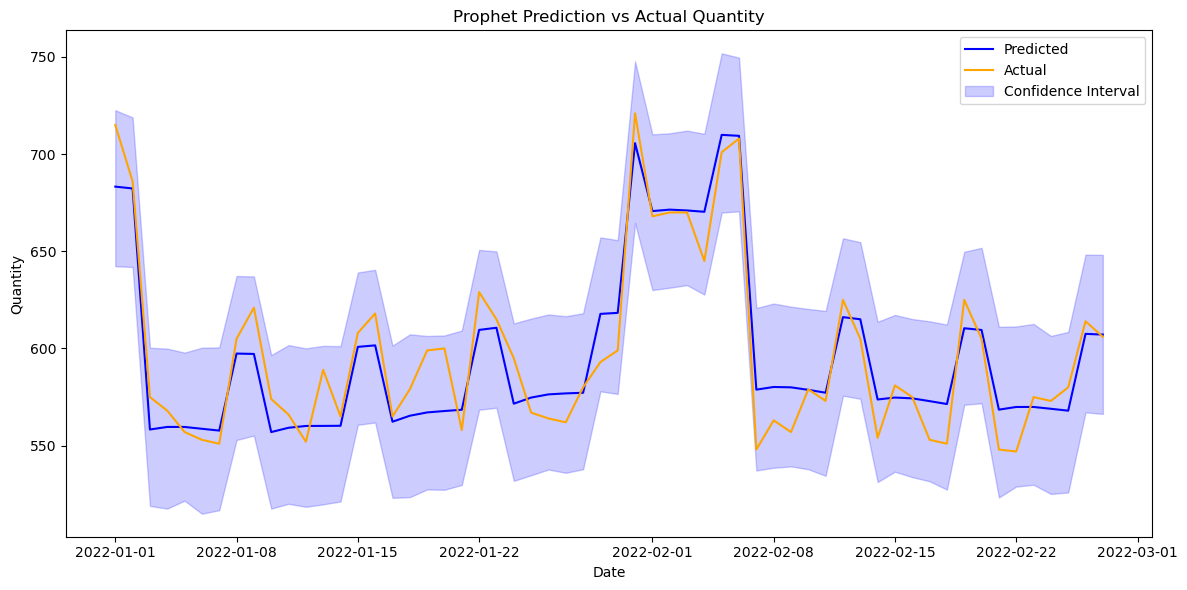

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# 准备测试数据
test_plot = test_df.rename(columns={"calendar_date": "ds", "quantity": "y"})

# 合并预测值与真实值
compare = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].merge(
    test_plot[["ds", "y"]], on="ds", how="left"
)

# 去除没有真实值的行（以防test_df日期不匹配）
compare = compare.dropna(subset=["y"])

# 计算 MAPE（Mean Absolute Percentage Error）
mape = mean_absolute_percentage_error(compare["y"], compare["yhat"])
print(f"预测 MAPE: {mape:.4f} ({mape * 100:.2f}%)")

# 可视化预测结果 vs 实际值
plt.figure(figsize=(12, 6))
plt.plot(compare["ds"], compare["yhat"], label="Predicted", color="blue")
plt.plot(compare["ds"], compare["y"], label="Actual", color="orange")
plt.fill_between(compare["ds"], compare["yhat_lower"], compare["yhat_upper"],
                 color="blue", alpha=0.2, label="Confidence Interval")
plt.title("Prophet Prediction vs Actual Quantity")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/general/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/general/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/envs/general/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an nda

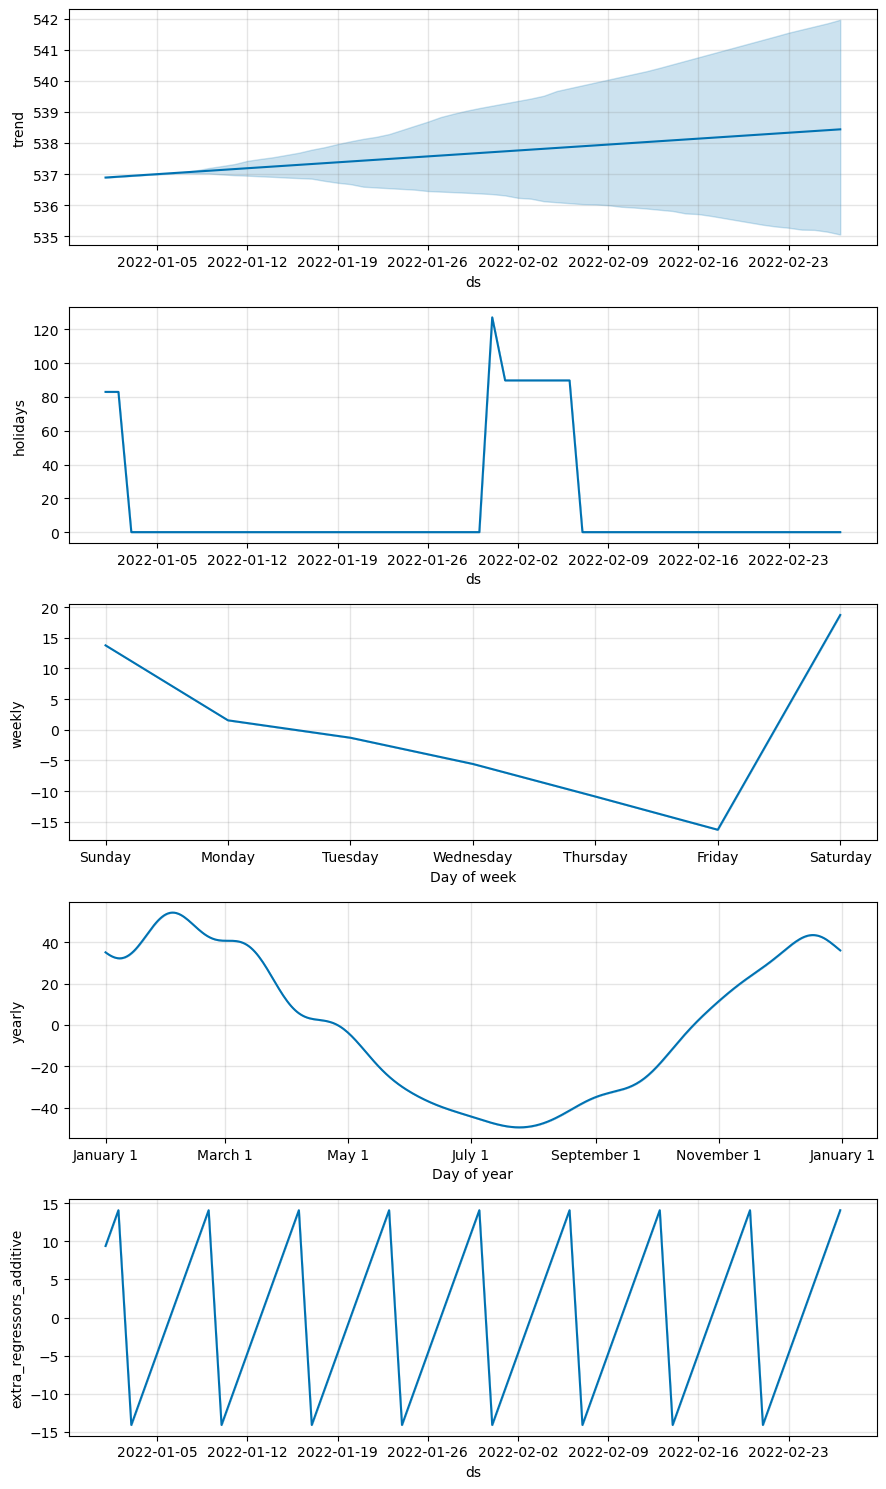

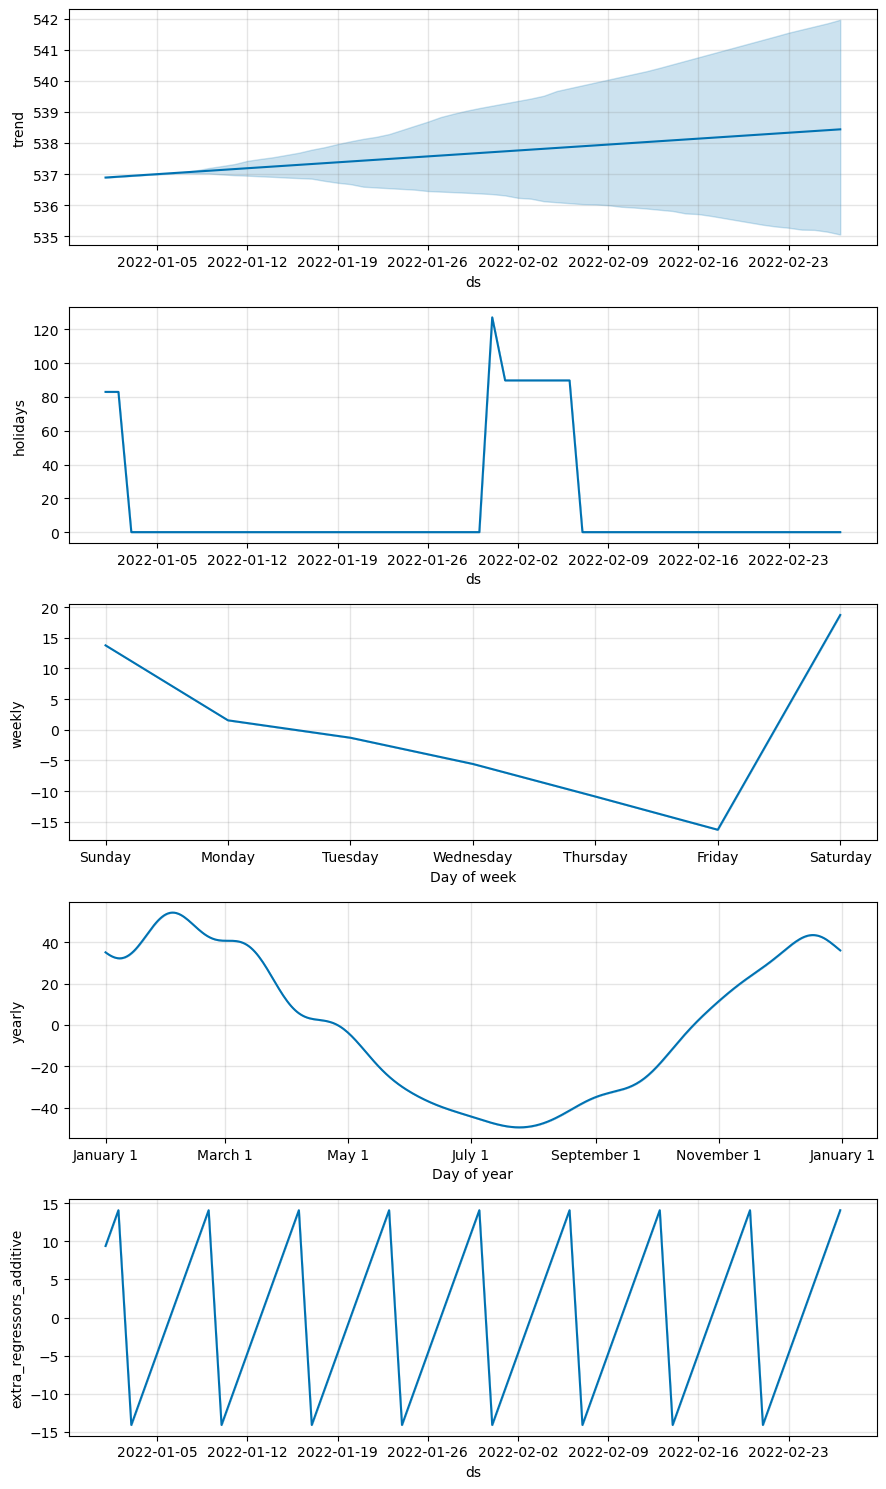

In [105]:
m.plot_components(forecast)

# 3-5月预测

In [77]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 原始训练数据（保留）
# train_df 中已有列：ds（日期）, y（销量）, day_of_week（数值或one-hot），holiday（字符串）

# ✅ 创建 2022-03-01 ~ 2022-05-31 的预测日期框架
future_df = pd.DataFrame({
    "ds": pd.date_range(start="2022-03-01", end="2022-05-31")
})

# 补充 day_of_week
future_df["day_of_week"] = future_df["ds"].dt.weekday

# ✅ 合并 holiday 信息（从你的完整节假日表 df_cleaned_ultra 中提取）
# 注意：df_cleaned_ultra 应该包含 calendar_date（日期）和 holiday（节假日名）
future_df = future_df.merge(
    df_cleaned_ultra[["calendar_date", "holiday"]],
    how="left",
    left_on="ds",
    right_on="calendar_date"
).drop(columns=["calendar_date"])

In [86]:
# 训练用节假日数据，包含所有节日
prophet_holidays = train_df[["ds", "holiday"]].dropna().drop_duplicates()
prophet_holidays["lower_window"] = -1
prophet_holidays["upper_window"] = 2

# Prophet holidays 参数需要列：holiday, ds, lower_window, upper_window
prophet_holidays = prophet_holidays[["holiday", "ds", "lower_window", "upper_window"]]

KeyError: "['ds'] not in index"

In [85]:
# 创建 Prophet 模型
m = Prophet(interval_width=0.95, holidays=prophet_holidays)

# 添加回归项（以 day_of_week 为数值，非 one-hot）
m.add_regressor("day_of_week")

# 训练
m.fit(train_df)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.